In [26]:
import logging
import os
import sys
import multiprocessing
import gensim 
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

In [3]:
path_io_files = '../../datasets/Word2Vec/'

### Base Google News

In [19]:
#http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
googlenews = os.path.join(path_io_files,'GoogleNews-vectors-negative300.bin.gz')
questions = os.path.join(path_io_files,'questions-words.txt')

In [8]:
model_googlenews = gensim.models.Word2Vec.load_word2vec_format(googlenews, binary=True)

In [11]:
evals = open(questions, 'r').readlines()
num_sections = len([l for l in evals if l.startswith(':')])
print('total evaluation sentences: {} '.format(len(evals) - num_sections))

total evaluation sentences: 19544 


In [13]:
def w2v_model_accuracy(model_googlenews):
    accuracy = model.accuracy(questions)
    sum_corr = len(accuracy[-1]['correct'])
    sum_incorr = len(accuracy[-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: a / total * 100
    print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, 
                                                                             percent(sum_corr), 
                                                                             percent(sum_incorr)))

In [14]:
w2v_model_accuracy(model_googlenews)

Total sentences: 13190, Correct: 77.08%, Incorrect: 22.92%


In [9]:
model_googlenews.most_similar("queen")

[('queens', 0.7399442195892334),
 ('princess', 0.7070531845092773),
 ('king', 0.6510956883430481),
 ('monarch', 0.6383601427078247),
 ('very_pampered_McElhatton', 0.6357026696205139),
 ('Queen', 0.6163408756256104),
 ('NYC_anglophiles_aflutter', 0.6060680150985718),
 ('Queen_Consort', 0.592379629611969),
 ('princesses', 0.5908075571060181),
 ('royal', 0.5637185573577881)]

### Base Media Cloud

In [27]:
#mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v')
mediacloud = os.path.join(path_io_files, 'MediaCloud_w2v_trigrams')

In [28]:
model_mediacloud = gensim.models.Word2Vec.load(mediacloud)

In [29]:
model_mediacloud.most_similar('fgv')

[('fundação_getúlio', 0.7404108047485352),
 ('vargas_fgv', 0.7010539770126343),
 ('fundação_getulio', 0.7001169323921204),
 ('ibre', 0.6558458209037781),
 ('eesp', 0.6423794031143188),
 ('getulio_vargas', 0.6356330513954163),
 ('eaesp', 0.628360390663147),
 ('economia_ibre', 0.625259518623352),
 ('economia_fundação', 0.6108883619308472),
 ('ibre_fgv', 0.6033610701560974)]

In [32]:
def build_neighbors(word, model, nviz=15):
    g = nx.Graph()
    g.add_node(word, {'color':'blue'})
    viz1 = model.most_similar(word, topn=nviz)
    g.add_weighted_edges_from([(word, v, w) for v,w in viz1 if w> 0.5] )
    for v in viz1:
        g.add_weighted_edges_from([(v[0], v2, w2) for v2,w2 in model.most_similar(v[0])])
    return g

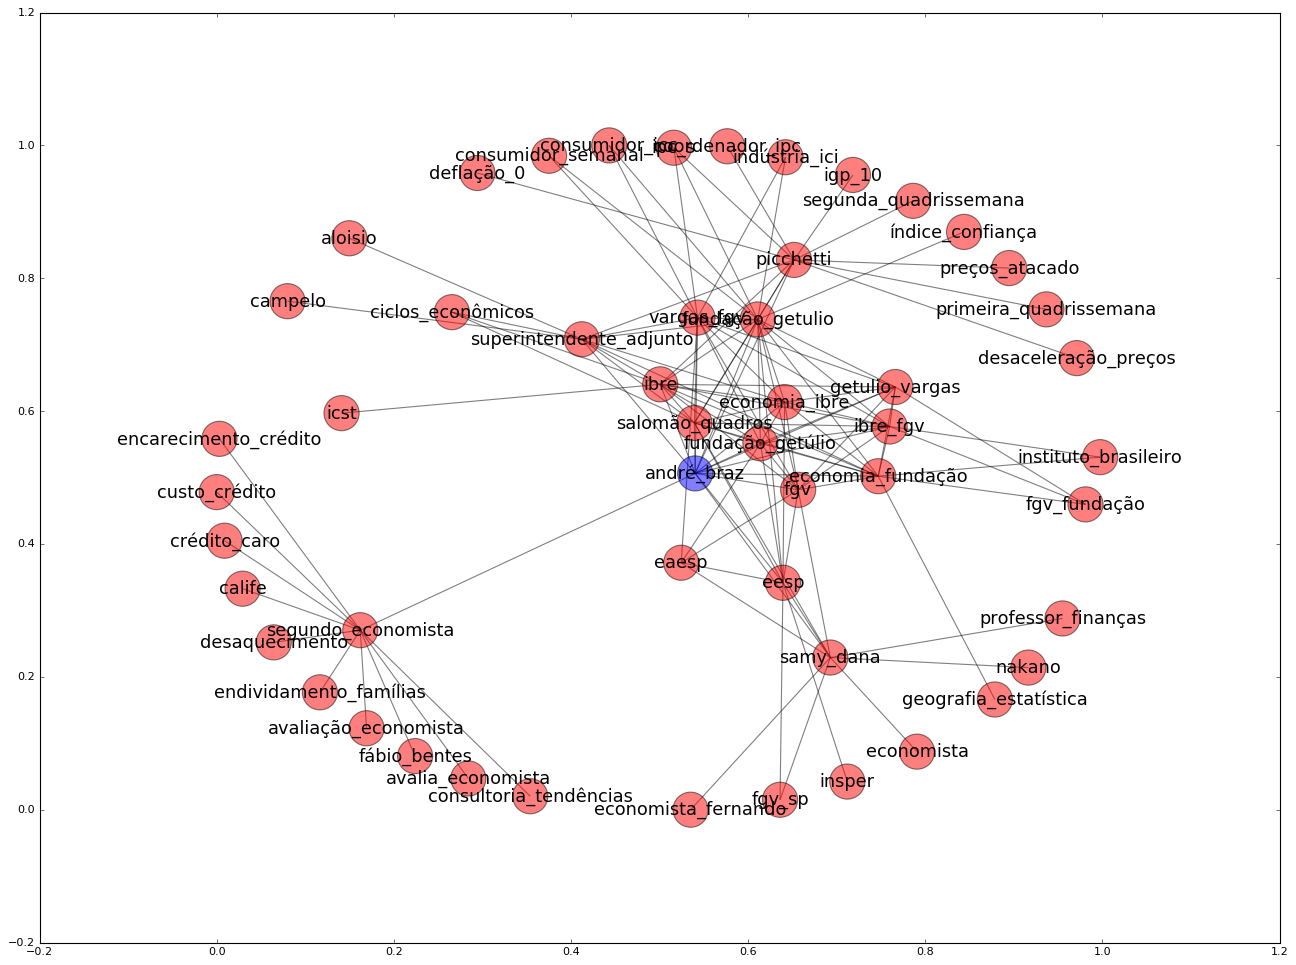

In [36]:
word = 'andré_braz'
g = build_neighbors(word, model_mediacloud)
cols = ['r']*len(g.nodes()); cols[g.nodes().index(word)]='b'
pos = nx.spring_layout(g, iterations=100)
nx.draw_networkx(g,pos=pos, node_color=cols, node_size=1000, alpha=0.5, font_size=16)
#nx.draw_networkx_labels(g, pos,dict(zip(g.nodes(),g.nodes())))

### Base Wikipedia

In [ ]:
#https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2
#wikipedia = os.path.join(path_io_files,'enwiki-latest-pages-articles.xml.bz2')

#https://github.com/3Top/word2vec-api#where-to-get-a-pretrained-models

In [ ]:
wiki = WikiCorpus(trained_model_file, lemmatize=False, dictionary={})

with open(os.path.join(path_io_files,'wikimedia_processed'), 'w') as f:
    for text in wiki.get_texts():
        output.write(' '.join(text) + "\n")

model = Word2Vec(LineSentence(inp), size=400, window=5, min_count=5, workers=multiprocessing.cpu_count())
# trim unneeded model memory = use (much) less RAM
model.init_sims(replace=True)
model.save(outp)